# PART III: CLASSIFICATION (pre-trained word2vec)

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Import dataset as pandas data frame.
df_jobads = pd.read_csv('data_jobads_final.csv', index_col=None)

# Apply small modifications.
df_jobads['job_description'] = df_jobads['job_description'].str.replace('\n', ' ')
df_jobads = df_jobads.dropna().reset_index(drop=True)
df_jobads = df_jobads.iloc[:,-2:]

print('The shape of the experiment dataset is:', df_jobads.shape)
df_jobads.head(2)

The shape of the experiment dataset is: (1166, 2)


,job_description,label
0,silver stream healthcare group offer great emp...,registered_nurse
1,create a better future for yourself recruitne...,registered_nurse


In [3]:
# Check the 'label' column for unique values.
labels = df_jobads['label'].unique().tolist()

print(labels)

['registered_nurse', 'electrician', 'data_analyst']


In [4]:
# Create 'id2label', 'label2id' variables for mapping the labels.
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print(label2id)

{0: 'registered_nurse', 1: 'electrician', 2: 'data_analyst'}
{'registered_nurse': 0, 'electrician': 1, 'data_analyst': 2}


In [6]:
# Encode the 'label' column.
df_jobads['label_encoded'] = df_jobads.label.map(lambda x: label2id[x.strip()])

df_jobads.head(2)

,job_description,label,label_encoded
0,silver stream healthcare group offer great emp...,registered_nurse,0
1,create a better future for yourself recruitne...,registered_nurse,0


In [7]:
# Load the pre-trained Word2Vec model
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
# Lowercasing and tokenizing
def preprocess_text_word2vec(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    
    return tokens

In [9]:
df_jobads['processed_jd'] = df_jobads['job_description'].apply(preprocess_text_word2vec)

df_jobads.head(2)

,job_description,label,label_encoded,processed_jd
0,silver stream healthcare group offer great emp...,registered_nurse,0,"[silver, stream, healthcare, group, offer, gre..."
1,create a better future for yourself recruitne...,registered_nurse,0,"[create, a, better, future, for, yourself, rec..."


In [10]:
def embed_tokens(tokens_list, model):
    vectors = [model[word] for word in tokens_list if word in model]
    if vectors:
        # Averaging the vectors (You could choose another aggregation method)
        embedding = np.mean(vectors, axis=0)
    else:
        # Use a zero vector if none of the tokens were found in the Word2Vec model
        embedding = np.zeros(model.vector_size)
        
    return embedding

In [11]:
# Apply the function to embed each row's tokens in the DataFrame
df_jobads['vectors'] = df_jobads['processed_jd'].apply(lambda x: embed_tokens(x, word2vec))
# This will add a new column 'word2vec_embedding' where each row contains the aggregated Word2Vec embedding for its tokens

print('The shape of the first tensor:', df_jobads.iat[0, -1].shape, '\n')
print('The shape of the second tensor:', df_jobads.iat[1, -1].shape, '\n')
print(df_jobads.iat[0, -1], '\n')

df_jobads.head(2)

The shape of the first tensor: (300,) 

The shape of the second tensor: (300,) 

[-0.04270588  0.0259989   0.0150202   0.03140387 -0.04899873 -0.00490635
  0.03562238 -0.06399295  0.05567776  0.01420705 -0.03350464 -0.06936279
 -0.00990608  0.0621248  -0.07119966  0.05226553  0.02378007  0.08027887
 -0.02390202 -0.04093122  0.0047953  -0.01274216  0.00567297  0.0482306
  0.01729175 -0.01818985 -0.09998598  0.03697966 -0.01236241 -0.02741816
  0.01287915 -0.05705226 -0.04490084 -0.03154047 -0.01284505 -0.02650193
  0.01196809  0.0081192   0.0341109   0.00475274  0.0509129  -0.0160897
  0.01557197 -0.00611844 -0.04048933 -0.0985489  -0.03566245  0.02680518
 -0.02716161  0.02438457  0.01009924  0.02503024 -0.01809056  0.02118859
 -0.01346281 -0.00171159 -0.0588086  -0.04148743  0.00619266 -0.06870976
 -0.07649664  0.05115747 -0.08261833 -0.07243258  0.00834871  0.03108732
 -0.05716189  0.09859857 -0.02301718  0.03350815  0.01343249  0.00344172
  0.10291003  0.00804558 -0.05994371 -0.06603

,job_description,label,label_encoded,processed_jd,vectors
0,silver stream healthcare group offer great emp...,registered_nurse,0,"[silver, stream, healthcare, group, offer, gre...","[-0.04270588, 0.0259989, 0.015020199, 0.031403..."
1,create a better future for yourself recruitne...,registered_nurse,0,"[create, a, better, future, for, yourself, rec...","[-0.067376204, 0.035147008, 0.023164311, 0.027..."


In [12]:
X = np.stack(df_jobads['vectors'].values)  # Convert the list of vectors into a numpy array
y = df_jobads['label_encoded'].values      # Get the target values

In [13]:
# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=630)
print('TRAINING shape:', X_train.shape)
print('TEST shape:', X_test.shape)

TRAINING shape: (816, 300)
TEST shape: (350, 300)


In [14]:
# Initialize the Logistic Regression model
clf = LogisticRegression(max_iter=1000, class_weight='balanced')  # Increased max_iter for convergence

# Fit the model on the training data
clf.fit(X_train, y_train)

# You can now use log_reg to make predictions and evaluate the model
preds = clf.predict(X_test)
labels = y_test

classification report: LOGISTIC REGRESSION (TF-IDF + BOW)

               precision    recall  f1-score   support

           0       1.00      0.99      1.00       182
           1       0.98      0.96      0.97        49
           2       0.98      0.99      0.98       119

    accuracy                           0.99       350
   macro avg       0.98      0.98      0.98       350
weighted avg       0.99      0.99      0.99       350



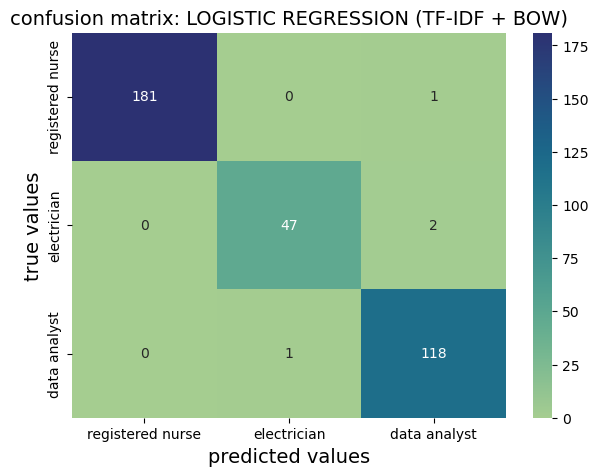

In [15]:
print('classification report: LOGISTIC REGRESSION (TF-IDF + BOW)\n\n', classification_report(labels, preds))

cm_labels = ['registered nurse', 'electrician', 'data analyst']
cm_matrix = confusion_matrix(labels, preds)
cm_title = 'confusion matrix: LOGISTIC REGRESSION (TF-IDF + BOW)'


plt.figure(figsize=(7, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='crest', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title(cm_title, fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.ylabel('true values', fontsize=14)

plt.show()

In [16]:
df_benchmark_train = pd.read_csv('ag_news_train.csv', index_col=None)
df_benchmark_test = pd.read_csv('ag_news_test.csv', index_col=None)

In [17]:
# Check the 'label' column for unique values.
labels = df_benchmark_train['label'].unique().tolist()

print(labels)

['business', 'sci/tech', 'sports', 'world']


In [18]:
# Create 'id2label', 'label2id' variables for mapping the labels.
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print(label2id)

{0: 'business', 1: 'sci/tech', 2: 'sports', 3: 'world'}
{'business': 0, 'sci/tech': 1, 'sports': 2, 'world': 3}


In [19]:
# Encode the 'label' column.
df_benchmark_train['label_encoded'] = df_benchmark_train.label.map(lambda x: label2id[x.strip()])
df_benchmark_test['label_encoded'] = df_benchmark_test.label.map(lambda x: label2id[x.strip()])

df_benchmark_test.head(2)

,text,label,label_encoded
0,Fears for T N pension after talks Unions repr...,business,0
1,The Race is On: Second Private Team Sets Laun...,sci/tech,1


In [20]:
df_benchmark_train['processed_text'] = df_benchmark_train['text'].apply(preprocess_text_word2vec)
df_benchmark_test['processed_text'] = df_benchmark_test['text'].apply(preprocess_text_word2vec)

df_benchmark_test.head(2)

,text,label,label_encoded,processed_text
0,Fears for T N pension after talks Unions repr...,business,0,"[fears, for, t, n, pension, after, talks, unio..."
1,The Race is On: Second Private Team Sets Laun...,sci/tech,1,"[the, race, is, on, second, private, team, set..."


In [21]:
df_benchmark_train['vectors'] = df_benchmark_train['processed_text'].apply(lambda x: embed_tokens(x, word2vec))
df_benchmark_test['vectors'] = df_benchmark_test['processed_text'].apply(lambda x: embed_tokens(x, word2vec))

df_jobads.head(2)

,job_description,label,label_encoded,processed_jd,vectors
0,silver stream healthcare group offer great emp...,registered_nurse,0,"[silver, stream, healthcare, group, offer, gre...","[-0.04270588, 0.0259989, 0.015020199, 0.031403..."
1,create a better future for yourself recruitne...,registered_nurse,0,"[create, a, better, future, for, yourself, rec...","[-0.067376204, 0.035147008, 0.023164311, 0.027..."


In [22]:
X_train = np.stack(df_benchmark_train['vectors'].values)
X_test = np.stack(df_benchmark_test['vectors'].values)
y_train = df_benchmark_train['label_encoded'].copy()
y_test = df_benchmark_test['label_encoded'].copy()
print('TRAINING shape:', X_train.shape)
print('TEST shape:', X_test.shape)

TRAINING shape: (120000, 300)
TEST shape: (7600, 300)


In [23]:
# Initialize the Logistic Regression model
clf = LogisticRegression(max_iter=1000, class_weight='balanced')  # Increased max_iter for convergence

# Fit the model on the training data
clf.fit(X_train, y_train)

# You can now use log_reg to make predictions and evaluate the model
preds = clf.predict(X_test)
labels = y_test

classification report: LOGISTIC REGRESSION (PRETRAINED WORD2WEC)

               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1900
           1       0.87      0.86      0.86      1900
           2       0.94      0.97      0.96      1900
           3       0.91      0.89      0.90      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



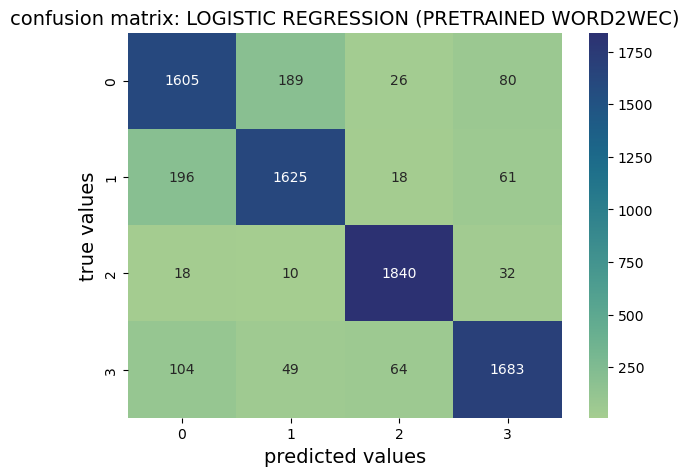

{0: 'business', 1: 'sci/tech', 2: 'sports', 3: 'world'}


In [24]:
print('classification report: LOGISTIC REGRESSION (PRETRAINED WORD2WEC)\n\n', classification_report(labels, preds))

cm_labels = np.unique(np.concatenate((labels, preds)))
cm_matrix = confusion_matrix(labels, preds)
cm_title = 'confusion matrix: LOGISTIC REGRESSION (PRETRAINED WORD2WEC)'


plt.figure(figsize=(7, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='crest', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title(cm_title, fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.ylabel('true values', fontsize=14)

plt.show()

print(id2label)